<a href="https://colab.research.google.com/github/jeonghojo00/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Handwritten Letters Classification

## Initial Setup

In [1]:
# Data Import
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
import time
import copy

import torch
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

try:
  import optuna
except:
  !pip install optuna
  import optuna

try:
  import pytorch_lightning as pl
except:
  !pip install pytorch-lightning
  import pytorch_lightning

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/DB'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/DB
annotations  dog.jpg	   mnist	       study.pkl
coco2017     enron_corpus  study_20220407.pkl  train2017


## Explore MNIST datset

### Load MNIST dataset from torchvision datasets

In [4]:
train_ds = MNIST("mnist", train=True, download=True, transform=ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=ToTensor())

In [5]:
# Dataset short review
print("Train_shape: ", train_ds.data.shape)
print("Train_label_shape: ", train_ds.targets.shape)
print("Test_shape: ", test_ds.data.shape)

Train_shape:  torch.Size([60000, 28, 28])
Train_label_shape:  torch.Size([60000])
Test_shape:  torch.Size([10000, 28, 28])


### Data Observations

In [6]:
labels = train_ds.targets
labels = pd.DataFrame(data=list(labels), columns=['label'])
labels['value'] = 1
labels_counts = labels.groupby('label').sum()
labels_counts

,value
label,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


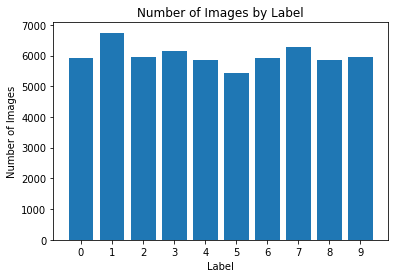

In [7]:
plt.bar(labels_counts.index, labels_counts.value)
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks(list(labels_counts.index))
plt.title("Number of Images by Label")
plt.show()

Train data is equally distributed among labels

### Show sample images

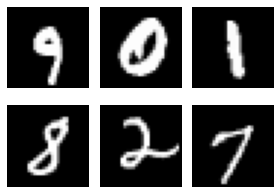

[9, 0, 1, 8, 2, 7]


In [8]:
# Show some randomly selected Train images and lables
import random

numImages = 6

random_index = np.random.choice(range(len(train_ds)), numImages)

plt.figure(figsize=(4,3))
plt.title("Some Random Training Images")
for i in range(numImages):
    plt.subplot(2,3,i+1)
    plt.imshow(train_ds.data[random_index[i]],cmap=plt.get_cmap("gray"))
    plt.axis("off")
plt.tight_layout()
plt.show() 

selected_lables = [train_ds.targets[idx].item() for idx in random_index]
print(selected_lables)

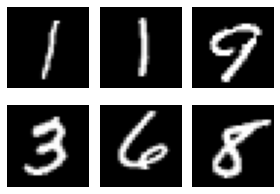

[1, 1, 9, 3, 6, 8]


In [9]:
random_index = np.random.choice(range(len(test_ds)), numImages)

plt.figure(figsize=(4,3))
plt.title("Some Random Testing Images")
for i in range(numImages):
    plt.subplot(2,3,i+1)
    plt.imshow(test_ds.data[random_index[i]],cmap=plt.get_cmap("gray"))
    plt.axis("off")
plt.tight_layout()
plt.show() 

selected_lables = [test_ds.targets[idx].item() for idx in random_index]
print(selected_lables)

Now, we see that train and test datasets have the same shapes and formats that we can work in the same way

## Experiment and Find the best model and hyperparameters

In [4]:
EPOCHS = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision.transforms import transforms

def get_mnist(param_name, batch_size):

    img_size_dict = {
        "resnet18": 28,
        "inception_v3": 299,
        "densenet161": 29,
        "alexnet": 63,
        "mobilenet_v3_small": 32,
        "vgg16": 32,
        "mnasnet1_0": 96}

    '''
        Replace regular input size of each model with minimum possible input size for each model 
        to reduce number of hyperparameters and to reduce memory usages.

        ** Regular input size of each model
        "resnet18": 224,
        "inception_v3": 299,
        "densenet161": 224,
        "alexnet": 227,
        "mobilenet_v3_small": 224,
        "vgg16": 224,
        "mnasnet1_0": 224

    '''
    img_size = img_size_dict[param_name]

    transform=transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.ToTensor(),
    ])

    # Get Dataset
    train_ds = MNIST("mnist", train=True, download=True, transform=transform)
    test_ds = MNIST("mnist", train=False, download=True, transform=transform)

    train_len = len(train_ds)
    test_len = len(test_ds)

    # One batch includes 64 images and labels
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, test_dl, train_len, test_len

In [6]:
def get_model(model_name: str = "resnet18"):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=False, num_classes=10)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif model_name == "inception_v3":
        model = models.inception_v3(pretrained=False, num_classes=10)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    elif model_name == "densenet161":
        model = models.densenet161(pretrained=False, num_classes=10)
        model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=False, num_classes=10)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif model_name == "mobilenet_v3_small":
        model = models.mobilenet_v3_small(pretrained=False, num_classes=10)
        model.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=False, num_classes=10)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    elif model_name == "mnasnet1_0":
        model = models.mnasnet1_0(pretrained=False, num_classes=10)
        model.layers[0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    return model

    

In [7]:
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(params, model, trial):

    train_dataloader, val_dataloader, train_len, val_len = get_mnist(params["model_name"], params["batch_size"])

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    # Configure optimizer
    optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in train_dataloader:

            train_label = train_label.to(device)
            train_input = train_input.to(device)

            #output = model(train_input.float())
            output = model(train_input)
            if params["model_name"] == "inception_v3":
                output = output.logits
                
            #batch_loss = criterion(output, train_label.long())
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                val_input = val_input.to(device)

                #output = model(val_input.float())
                output = model(val_input)
                if params["model_name"] == "inception_v3":
                    output = output.logits

                #batch_loss = criterion(output, val_label.long())
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            
        accuracy = total_acc_val/val_len
            
        # Add prune mechanism
        trial.report(accuracy, epoch_num)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [8]:
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

    params = {
              'model_name': trial.suggest_categorical('model_name',["resnet18", "inception_v3", "densenet161", "alexnet", "mobilenet_v3_small", "vgg16", "mnasnet1_0"]),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer_name': trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
              'batch_size': trial.suggest_categorical("batch_size", [64, 128]),
              }
    
    # Get a model
    model = get_model(params["model_name"])
    
    accuracy = train_and_evaluate(params, model, trial)

    return accuracy

In [9]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

[I 2022-04-07 04:29:53,052] A new study created in memory with name: no-name-21a39c66-28ea-44e3-990c-8fa7b92e7935
[I 2022-04-07 04:33:04,660] Trial 0 finished with value: 0.9886 and parameters: {'model_name': 'resnet18', 'learning_rate': 0.00039003199920147774, 'optimizer_name': 'RMSprop', 'batch_size': 64}. Best is trial 0 with value: 0.9886.
[I 2022-04-07 04:36:20,396] Trial 1 finished with value: 0.9873 and parameters: {'model_name': 'alexnet', 'learning_rate': 0.00010747726095516019, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.9886.
[I 2022-04-07 04:39:36,507] Trial 2 finished with value: 0.1135 and parameters: {'model_name': 'alexnet', 'learning_rate': 0.04486077711347313, 'optimizer_name': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 0.9886.
[I 2022-04-07 04:47:08,182] Trial 3 finished with value: 0.9774 and parameters: {'model_name': 'mnasnet1_0', 'learning_rate': 0.0004150876609614039, 'optimizer_name': 'SGD', 'batch_size': 64}. Best is 

In [24]:
best_trial = study.best_trial
print("Best Trial with Parameters")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

Best Trial with Parameters
  model_name: resnet18
  learning_rate: 0.00021548830925679374
  optimizer_name: RMSprop
  batch_size: 64


In [11]:
optuna.visualization.plot_intermediate_values(study)

In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
optuna.visualization.plot_parallel_coordinate(study)

In [14]:
optuna.visualization.plot_param_importances(study)

In [21]:
optuna.visualization.plot_slice(study)

In [27]:
import joblib
joblib.dump(study, "study_20220407.pkl")

['study_20220407.pkl']

In [29]:
loaded_study = joblib.load("study_20220407.pkl")
print("Best trial until now:")
print(" Value: ", loaded_study.best_trial.value)
print(" Params: ")
for key, value in loaded_study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.9905
 Params: 
    model_name: resnet18
    learning_rate: 0.00021548830925679374
    optimizer_name: RMSprop
    batch_size: 64


## Train MNIST in accordance with the results of the above study

In [10]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 64

In [11]:
# Make a Dataloader
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [14]:
model = models.resnet18(pretrained=False, num_classes=len(labels_counts))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Because loaded resnet18 model takes 3 channels for its input and gray colored MNIST dataset has only 1 channel, I needed to change the conv0 layer to have 1 channel instead of 3.

In [12]:
class ResnetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-4)
        return optimizer

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

In [13]:
model = ResnetMNIST()

# Initialize a trainer
trainer = pl.Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=EPOCHS,
)

# Train the model
trainer.fit(model, train_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/DB/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleU

Training: 0it [00:00, ?it/s]

In [15]:
trainer.save_checkpoint("resnet18_mnist_20220407.pt")

## Evaluated the Trained Model

In [16]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [17]:
from tqdm.autonotebook import tqdm

In [19]:
inference_model = ResnetMNIST.load_from_checkpoint("resnet18_mnist_20220407.pt")

In [20]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/157 [00:00<?, ?it/s]

In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.987     0.998     0.992       980
           1      0.996     0.994     0.995      1135
           2      0.994     0.988     0.991      1032
           3      0.982     0.996     0.989      1010
           4      0.967     0.999     0.983       982
           5      0.992     0.987     0.989       892
           6      0.998     0.983     0.991       958
           7      0.971     0.996     0.983      1028
           8      0.991     0.987     0.989       974
           9      0.997     0.944     0.970      1009

    accuracy                          0.987     10000
   macro avg      0.987     0.987     0.987     10000
weighted avg      0.987     0.987     0.987     10000



## Inferences

In [23]:
test_imgs, test_labels = next(iter(test_dl))
print(len(test_labels))

64


In [24]:
preds, probs = get_prediction(test_imgs, inference_model)

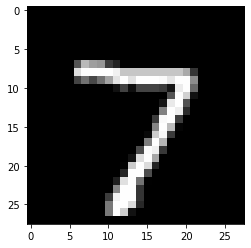

Predicted Label:  7
True Label:       7




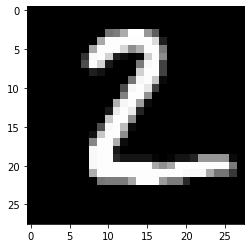

Predicted Label:  2
True Label:       2




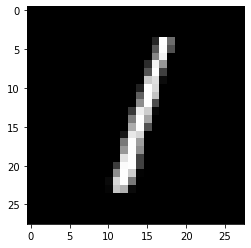

Predicted Label:  1
True Label:       1




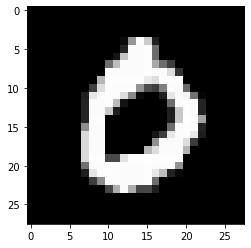

Predicted Label:  0
True Label:       0




In [27]:
for i in range(4):
    a_img = test_imgs[i].squeeze()
    a_label = test_labels[i]
    plt.imshow(a_img, cmap="gray")
    plt.show()
    print("Predicted Label: ", preds[i].item())
    print("True Label:      ", a_label.item())
    print("")
    print("")